In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, BatchNorm2d
from torch.optim import Adam
import torchvision.transforms as transforms


In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
torch.cuda.empty_cache()

In [4]:
# Load data
master_csv = pd.read_csv("MASTER_CSV_4.csv")
cwd = os.getcwd() 
folder_path = os.path.join(cwd, "session_1")

# # Process EEG data
# eeg_data = []
# for filename in tqdm(master_csv['filename']):
#     file_path = os.path.join(folder_path, filename)
#     file = pd.read_csv(file_path)
#     file = file.astype('float32')
#     mean, std = file.mean(), file.std()
#     normalized_data = (file - mean) / std
#     eeg_data.append(normalized_data)

# # Convert the list of normalized arrays to a NumPy array
# eeg_numpy = np.array(eeg_data)

# Define the target
label_emotion = master_csv['emotion'].values


In [5]:
# Save the NumPy array to a file
eeg_numpy = np.load('eeg_numpy.npy')

In [6]:
# Check unique values in the 'emotion' column
unique_emotions = master_csv['emotion'].unique()
print("Unique emotion labels in dataset:", unique_emotions)

# If the documentation specifies what each label represents, create a mapping
# For example, if 0=Neutral, 1=Sad, 2=Fear, 3=Happy
emotion_labels = ["Neutral", "Sad", "Fear", "Happy"]  # Make sure this matches the documentation

# Verify mapping by checking against the dataset
print("Mapping of labels to emotions:")
for i, label in enumerate(emotion_labels):
    print(f"{i} -> {label}")

Unique emotion labels in dataset: [2 3 0 1]
Mapping of labels to emotions:
0 -> Neutral
1 -> Sad
2 -> Fear
3 -> Happy


In [7]:
# Create validation set
train_x, val_x, train_y, val_y = train_test_split(eeg_numpy, label_emotion, test_size=0.25, random_state=13, stratify=label_emotion)

# Reshape and convert training data to torch format
train_x = train_x.reshape(-1, 1, 1001, 62)
train_x = torch.from_numpy(train_x).float()

# Convert the target into torch format
train_y = torch.from_numpy(train_y).long()

# Reshape and convert validation data to torch format
val_x = val_x.reshape(-1, 1, 1001, 62)
val_x = torch.from_numpy(val_x).float()

# Convert the target into torch format
val_y = torch.from_numpy(val_y).long()

In [8]:

# Define the convolutional neural network
class ConvNetGray(nn.Module):
    def __init__(self):
        super(ConvNetGray, self).__init__()
        self.conv_layers = Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = Sequential(
            Linear(128 * 125 * 7, 256),
            ReLU(),
            Linear(256, 64),
            Linear(64, 4)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [9]:

# Initialize model, optimizer, and loss function
model = ConvNetGray().to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = CrossEntropyLoss()

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Initialize lists for storing predictions and targets during validation
prediction_val, target_val = [], []

n_epochs = 20
early_stop_patience = 10
best_val_loss = float('inf')
no_improvement_count = 0

for epoch in range(1, n_epochs + 1):
    model.train()
    training_losses, training_accuracies = [], []

    for i in tqdm(range(0, train_x.size(0), 128)):
        batch_x, batch_y = train_x[i:i+128].to(device), train_y[i:i+128].to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == batch_y).float().sum()
        training_accuracies.append(correct.item() / batch_x.size(0))  # Corrected: use .item() to extract the scalar value

    train_loss = np.mean(training_losses)
    train_accuracy = np.mean(training_accuracies)  # Should work as .item() has converted tensors to Python scalars
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    validation_losses, validation_accuracies = [], []

    with torch.no_grad():
        for i in tqdm(range(0, val_x.size(0), 128)):
            batch_x, batch_y = val_x[i:i+128].to(device), val_y[i:i+128].to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            validation_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == batch_y).float().sum()
            validation_accuracies.append(correct.item() / batch_x.size(0))

            # Store predictions and targets for confusion matrix
            prediction_val.append(predicted.cpu())
            target_val.append(batch_y.cpu())

    val_loss = np.mean(validation_losses)
    val_accuracy = np.mean(validation_accuracies)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stop_patience:
        print(f'Early stopping at epoch {epoch} with minimum loss {best_val_loss}')
        break

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:11<00:00,  2.88s/it]


Epoch: 1, Training Loss: 1.6702, Validation Loss: 1.3614, Training Accuracy: 0.2899, Validation Accuracy: 0.3148


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:02<00:00,  2.50s/it]


Epoch: 2, Training Loss: 1.3434, Validation Loss: 1.3591, Training Accuracy: 0.3432, Validation Accuracy: 0.3255


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:02<00:00,  2.51s/it]


Epoch: 3, Training Loss: 1.3057, Validation Loss: 1.3479, Training Accuracy: 0.3844, Validation Accuracy: 0.3413


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.44s/it]


Epoch: 4, Training Loss: 1.2645, Validation Loss: 1.3347, Training Accuracy: 0.4203, Validation Accuracy: 0.3562


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.47s/it]


Epoch: 5, Training Loss: 1.2160, Validation Loss: 1.3148, Training Accuracy: 0.4584, Validation Accuracy: 0.3947


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.46s/it]


Epoch: 6, Training Loss: 1.1506, Validation Loss: 1.2716, Training Accuracy: 0.4984, Validation Accuracy: 0.4190


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.46s/it]


Epoch: 7, Training Loss: 1.0786, Validation Loss: 1.2600, Training Accuracy: 0.5384, Validation Accuracy: 0.4197


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.47s/it]


Epoch: 8, Training Loss: 0.9795, Validation Loss: 1.3156, Training Accuracy: 0.6041, Validation Accuracy: 0.4317


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:10<00:00,  2.80s/it]


Epoch: 9, Training Loss: 0.8791, Validation Loss: 1.3892, Training Accuracy: 0.6623, Validation Accuracy: 0.4102


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:02<00:00,  2.50s/it]


Epoch: 10, Training Loss: 0.7605, Validation Loss: 1.3688, Training Accuracy: 0.7303, Validation Accuracy: 0.4236


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:03<00:00,  2.55s/it]


Epoch: 11, Training Loss: 0.6381, Validation Loss: 1.4156, Training Accuracy: 0.7963, Validation Accuracy: 0.4238


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.44s/it]


Epoch: 12, Training Loss: 0.5222, Validation Loss: 1.5039, Training Accuracy: 0.8495, Validation Accuracy: 0.4245


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:02<00:00,  2.49s/it]


Epoch: 13, Training Loss: 0.4232, Validation Loss: 1.6810, Training Accuracy: 0.8927, Validation Accuracy: 0.4196


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:08<00:00,  2.74s/it]


Epoch: 14, Training Loss: 0.4765, Validation Loss: 1.6040, Training Accuracy: 0.8289, Validation Accuracy: 0.4422


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:09<00:00,  2.76s/it]


Epoch: 15, Training Loss: 0.4979, Validation Loss: 1.7358, Training Accuracy: 0.8059, Validation Accuracy: 0.4061


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:09<00:00,  2.77s/it]


Epoch: 16, Training Loss: 0.4592, Validation Loss: 1.7664, Training Accuracy: 0.8270, Validation Accuracy: 0.4351


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:07<00:00,  2.69s/it]

Epoch: 17, Training Loss: 0.3351, Validation Loss: 2.0763, Training Accuracy: 0.8950, Validation Accuracy: 0.3422
Early stopping at epoch 17 with minimum loss 1.2599941539764403


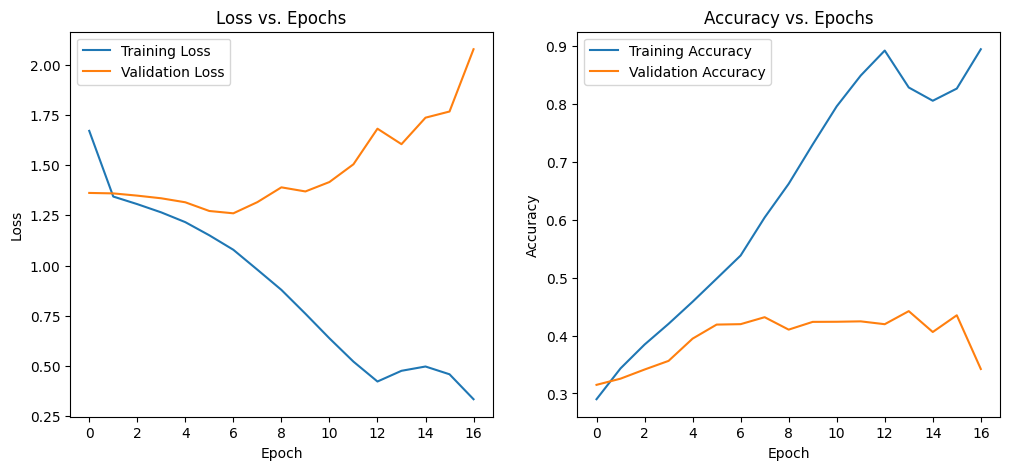

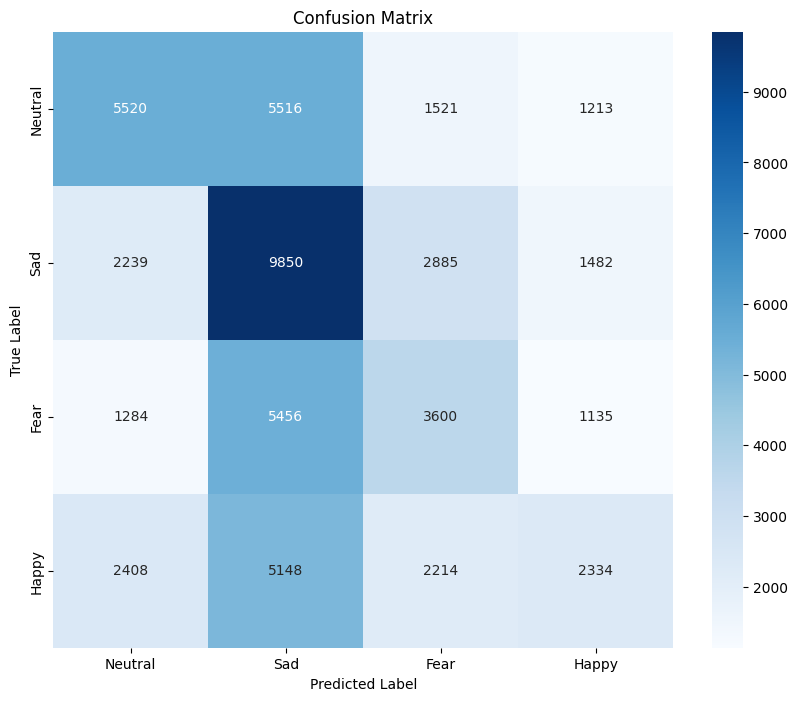

In [10]:
# Plot the learning curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix Calculation

all_predictions = np.concatenate([p.numpy() for p in prediction_val])
all_targets = np.concatenate([t.numpy() for t in target_val])
conf_matrix = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
